In [92]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir) + "/src/"
sys.path.insert(0, parentdir) 

from modeling import filter_depth, filter_rank, filter_value, value_path, value_EV, value_max, value_sum, value_levelmean
from modelchecking import trialwise_rewards, trialwise_greedydiff, trialwise_chooseleft
from analysis import Analyzer, lmm, glmm
from plots import set_helvetica_style
from utils import colormaps, report_p_value, strsimplify, get_stochasticity_levels, alphabet, format_games
from modeling import preprocess_data, make_pov_array
import json

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
type_ = "R"

In [94]:
# load data and get player
datafile = f"../data/raw/data_{type_}.json"
with open(datafile, 'r') as f:
    data = json.load(f)

/Users/jordanlei/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


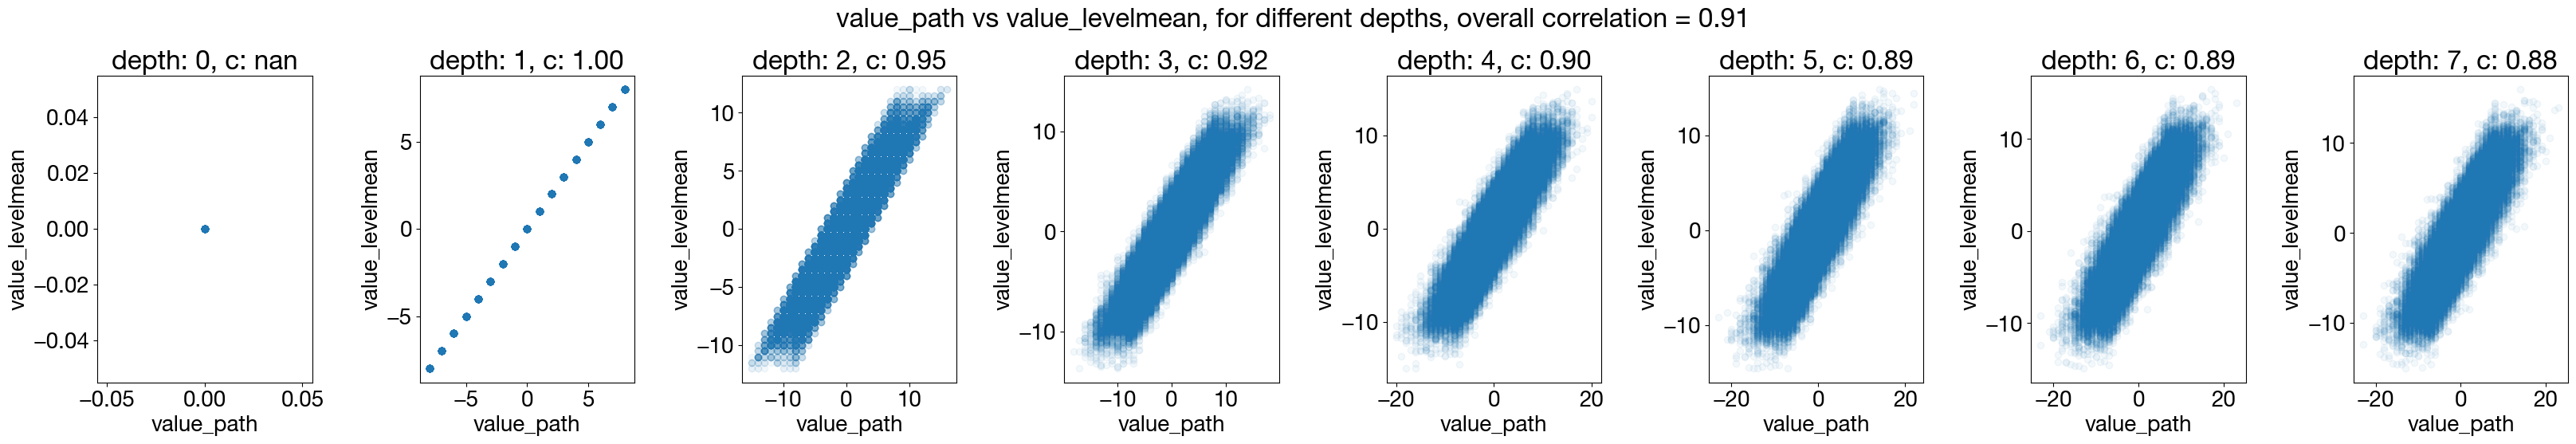

/Users/jordanlei/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


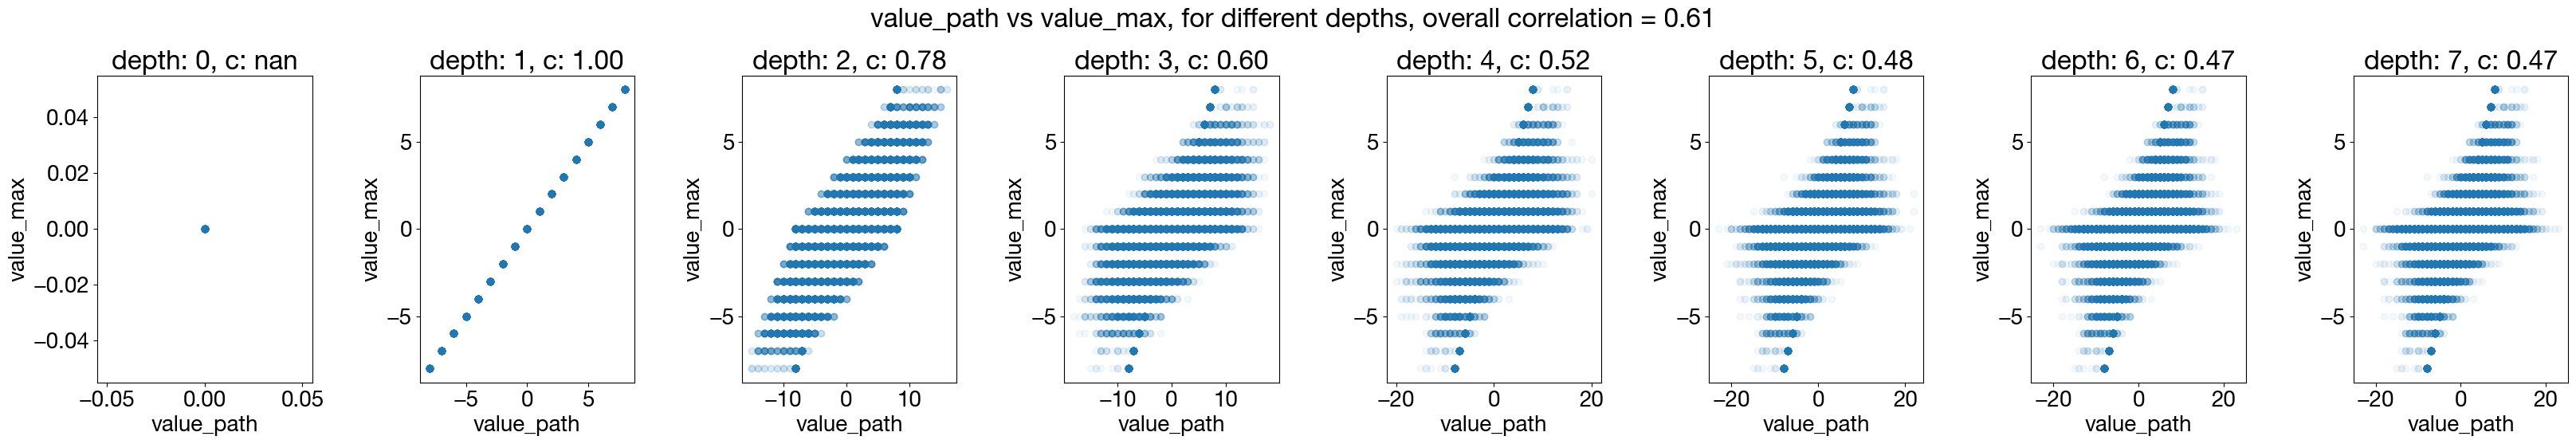

/Users/jordanlei/miniconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


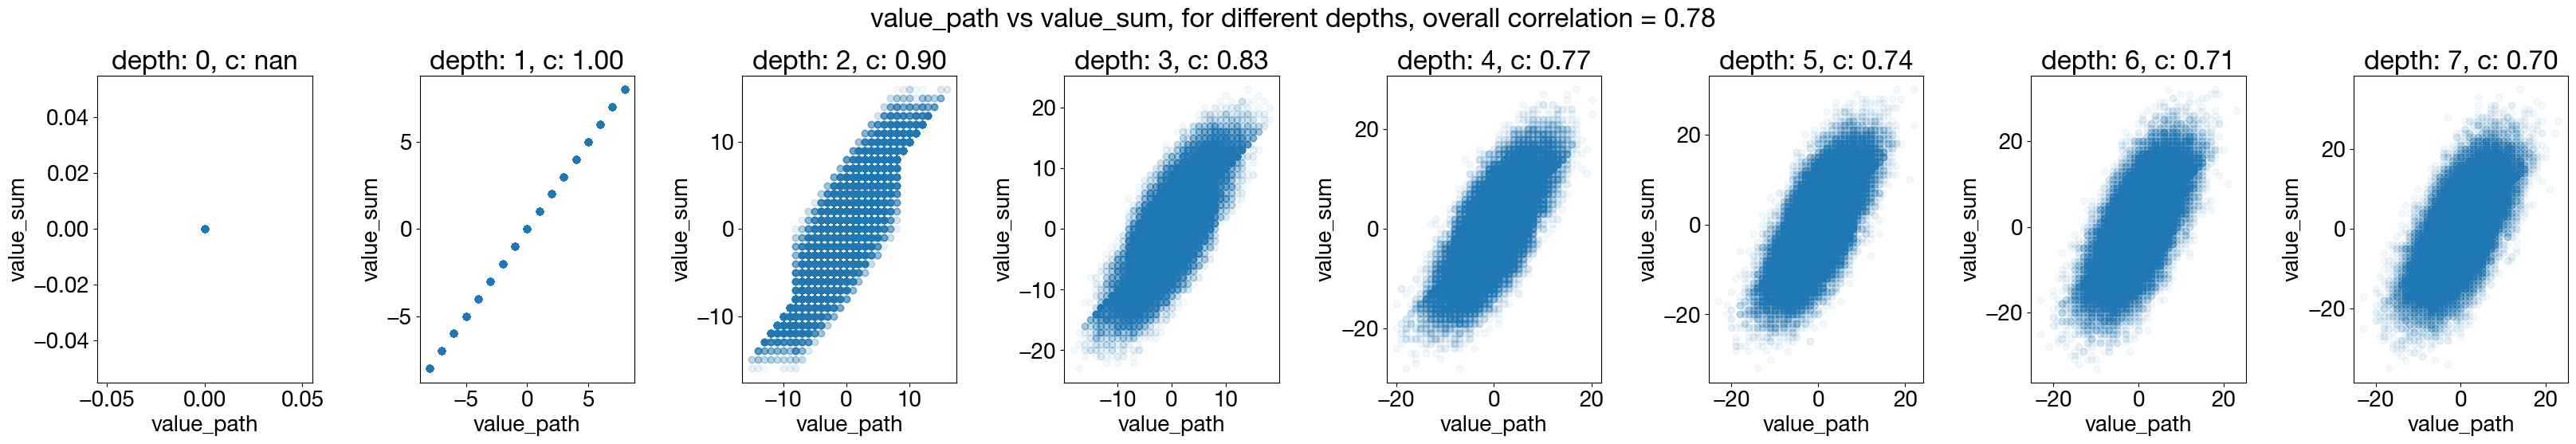

In [95]:
import xarray as xr
value_pairs = [
    (value_path, value_levelmean),
    (value_path, value_max),
    (value_path, value_sum),
]

for value_fn_1, value_fn_2 in value_pairs:
    value_list1 = []
    value_list2 = []
    for player in data.keys():
        games = format_games(data[player]["data"])
        game_data = preprocess_data(games)
        pov_array = make_pov_array(game_data.boards, game_data.paths)

        filter_pov_array = filter_depth(pov_array)
        value_list1.append(value_fn_1(filter_pov_array))
        value_list2.append(value_fn_2(filter_pov_array))

    value_array1 = np.array(value_list1)
    value_array2 = np.array(value_list2)
    fig, axs = plt.subplots(1, 8, figsize=(40, 5))
    plt.subplots_adjust(wspace=0.5)
    for i in range(8):
        ax = axs[i]
        ax.scatter(value_array1[:, i].flatten(), value_array2[:, i].flatten(), alpha = 0.05)
        ax.set_xlabel(value_fn_1.__name__)
        ax.set_ylabel(value_fn_2.__name__)
        ax.set_title(f"depth: {i}, c: {np.corrcoef(value_array1[:, i].flatten(), value_array2[:, i].flatten())[0, 1]:.2f}")

    plt.suptitle(f"{value_fn_1.__name__} vs {value_fn_2.__name__}, for different depths, overall correlation = {np.corrcoef(value_array1.flatten(), value_array2.flatten())[0, 1]:.2f}", y=1.05)
    plt.show()


0 R
0 <function value_path at 0x132f2f600> <function value_levelmean at 0x132f2f6a0>
1 <function value_path at 0x132f2f600> <function value_max at 0x132f2f7e0>
2 <function value_path at 0x132f2f600> <function value_sum at 0x132f2f740>
3 <function value_path at 0x132f2f600> <function value_EV at 0x132f2f560>
1 V
0 <function value_path at 0x132f2f600> <function value_levelmean at 0x132f2f6a0>
1 <function value_path at 0x132f2f600> <function value_max at 0x132f2f7e0>
2 <function value_path at 0x132f2f600> <function value_sum at 0x132f2f740>
3 <function value_path at 0x132f2f600> <function value_EV at 0x132f2f560>
2 T
0 <function value_path at 0x132f2f600> <function value_levelmean at 0x132f2f6a0>
1 <function value_path at 0x132f2f600> <function value_max at 0x132f2f7e0>
2 <function value_path at 0x132f2f600> <function value_sum at 0x132f2f740>
3 <function value_path at 0x132f2f600> <function value_EV at 0x132f2f560>


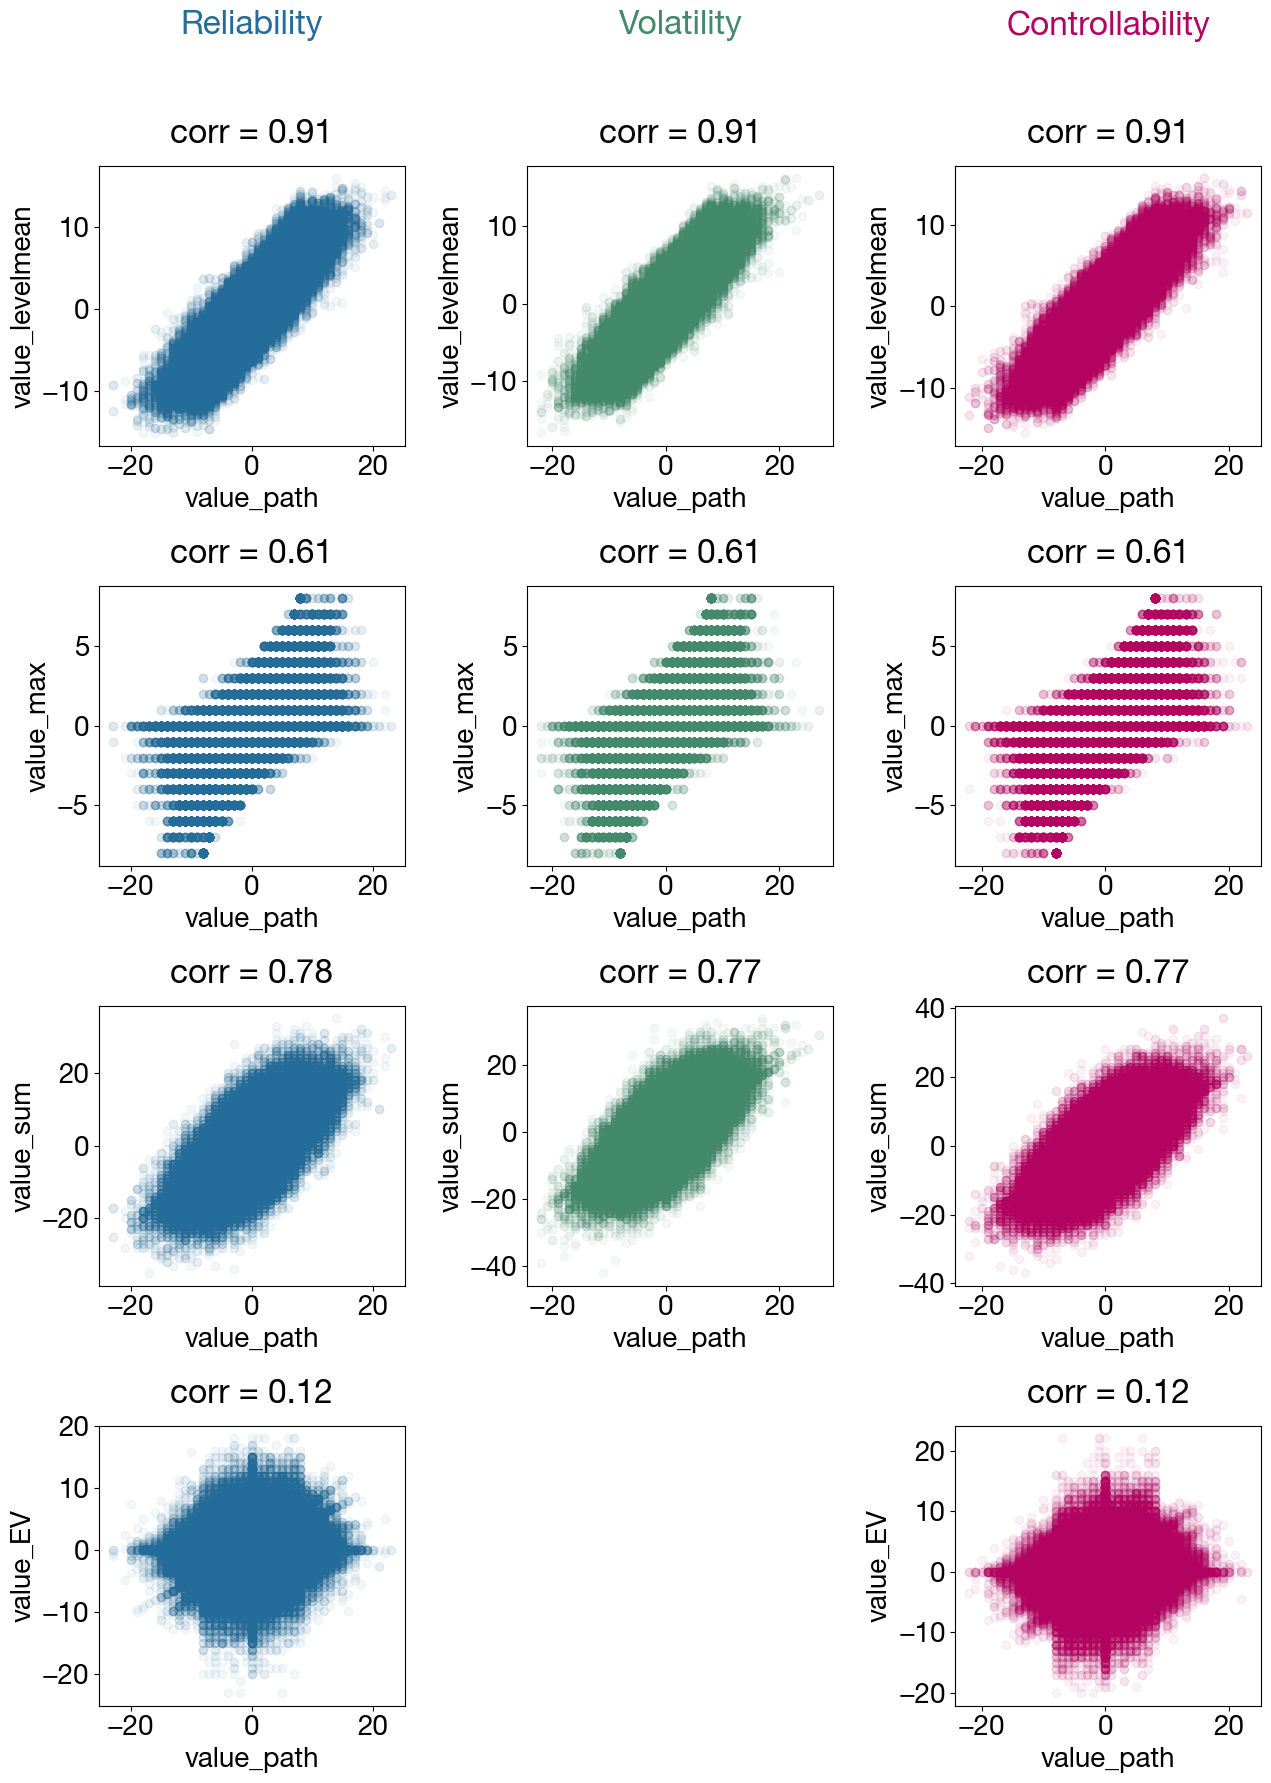

In [104]:
value_pairs = [
    (value_path, value_levelmean),
    (value_path, value_max),
    (value_path, value_sum),
    (value_path, value_EV),
]

def get_colormap(type_):
    return {"R": colormaps["arctic"], "T": colormaps["berry"], "V": colormaps["grass"]}[type_]

fig, axs = plt.subplots(len(value_pairs), 3, figsize=(15, len(value_pairs) * 5), gridspec_kw={'hspace': 0.5, 'wspace': 0.4})

for t, type_ in enumerate(["R", "V", "T"]):
    print(t, type_)
    # load data and get player
    datafile = f"../data/raw/data_{type_}.json"
    with open(datafile, 'r') as f:
        data = json.load(f)

    colormap = get_colormap(type_)

    for i, (value_fn_1, value_fn_2) in enumerate(value_pairs):
        print(i, value_fn_1, value_fn_2)
        if i == 0: 
            ax = axs[i, t]
            ax.text(0.5, 1.5, {type_: "Reliability", "V": "Volatility", "T": "Controllability"}[type_], ha='center', va='center', fontsize=24, color = colormap(0.5), transform=ax.transAxes)
            
        if type_ == "V" and value_fn_2 == value_EV:
            ax = axs[i, t]
            ax.set_visible(False)
            continue

        value_list1 = []
        value_list2 = []
        for player in data.keys():
            games = format_games(data[player]["data"])
            game_data = preprocess_data(games)
            pov_array = make_pov_array(game_data.boards, game_data.paths)

            filter_pov_array = filter_depth(pov_array)
            value_list1.append(value_fn_1(filter_pov_array, variant = type_, value_params = {}))
            value_list2.append(value_fn_2(filter_pov_array, variant = type_, value_params = {}))

        value_array1 = np.array(value_list1)
        value_array2 = np.array(value_list2)
        ax = axs[i, t]
        ax.scatter(value_array1.flatten(), value_array2.flatten(), alpha = 0.05, color = colormap(0.5))
        ax.set_xlabel(value_fn_1.__name__)
        ax.set_ylabel(value_fn_2.__name__)
        ax.set_title(f"corr = {np.corrcoef(value_array1.flatten(), value_array2.flatten())[0, 1]:.2f}", y=1.05)